In [2]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [3]:
#load single bank data as dataframe
bank_df = pd.read_csv('dist_csvs/income_to_amount_dist_.csv')
inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [4]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
inc_df.head()

,year,income,amount,count_income
0,2014,1,1,2
1278277,2007,1,339,1
1278276,2007,1,336,1
1278275,2007,1,328,1
1278274,2007,1,321,1


In [5]:
#bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
cnt_amt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count())
cnt_amt_df.rename(columns={'pct_amt':'count_amt'}, inplace=True)
cnt_amt_df['amount'] = cnt_amt_df.index
cnt_amt_df['pct_of_cnt'] = cnt_amt_df.count_amt.divide(other=cnt_amt_df.count_amt.sum())
cnt_amt_df['cumul_pct_cnt'] = cnt_amt_df.pct_of_cnt.cumsum()

#create percent and cumulative percents by value
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
total = inc_df.groupby(['income']).pct_inc.count().sum()

#create percent and cumulative percents by count and count times amount
cnt_inc_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count())
cnt_inc_df.rename(columns={'pct_inc':'count_inc'}, inplace=True)
cnt_inc_df['income'] = cnt_inc_df.index
cnt_inc_df['pct_of_cnt'] = cnt_inc_df.count_inc.divide(other=cnt_inc_df.count_inc.sum())
cnt_inc_df['cumul_pct_cnt'] = cnt_inc_df.pct_of_cnt.cumsum()



588.274665059 std
543.418841138 mean
415.0 median
6000.0 max mult
0.000357142857143 min mult
2000.0 98%
682.0 q3
231.0 q1
36.0 02%
451.0 iqr
-445.5 min_q 1358.5 max_q


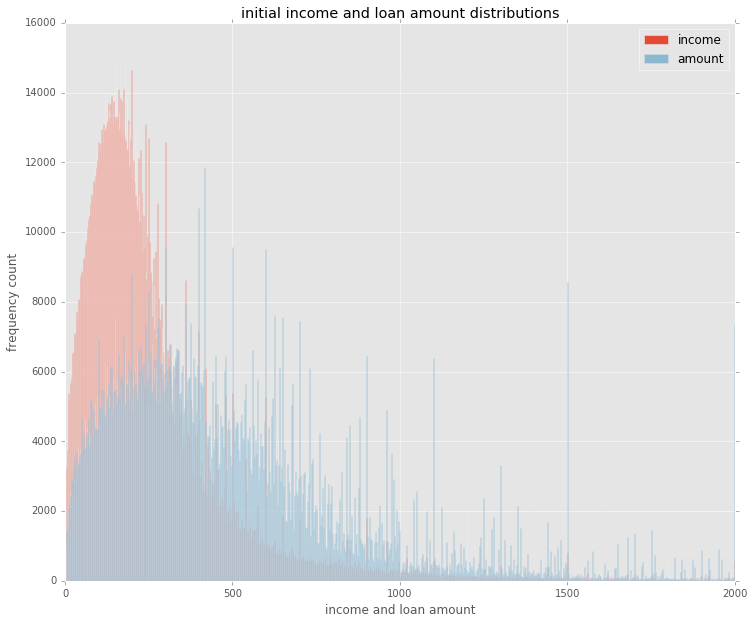

In [6]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), '98%')
print(bank_df.amount.quantile(q=.75), 'q3')
print(bank_df.amount.quantile(q=.25), 'q1')
print(bank_df.amount.quantile(q=.02), '02%')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5 * iqr #potential lower bound for quality
max_q = q3 + 1.5 * iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,2000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz



iteration 1
name 0 to 20
std 98.1918907637
mean 134.831965333
median 114.0
max_mult 430.0
med_mult 10.5
min_mult 0.0526315789474
q98 388.0
q02 7.0
q75 190.0
q25 57.0
iqr 133.0
min_q -142.5
max_q 389.5
count of loans 41276
pct of total loans 1.8621698366


iteration 2
name 0 to 20
std 91.0976708609
mean 129.350146902
median 112.0
max_mult 388.0
med_mult 10.277777777777779
min_mult 0.0526315789474
q98 350.0
q02 7.0
q75 184.0
q25 56.0
iqr 128.0
min_q -136.0
max_q 376.0
count of loans 41276
pct of total loans 1.8621698366


iteration 3
name 0 to 20
std 89.2959908115
mean 127.882632914
median 111.0
max_mult 375.0
med_mult 10.2
min_mult 0.0526315789474
q98 344.0
q02 7.0
q75 182.0
q25 56.0
iqr 126.0
min_q -133.0
max_q 371.0
count of loans 41276
pct of total loans 1.8621698366


iteration 4
name 0 to 20
std 88.3564775922
mean 127.102759851
median 111.0
max_mult 370.0
med_mult 10.166666666666666
min_mult 0.0526315789474
q98 340.0
q02 7.0
q75 181.0
q25 56.0
iqr 125.0
min_q -131.5
max_q 368.5
c

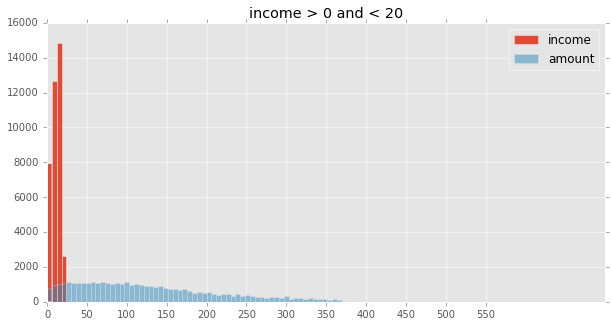



iteration 1
name 20 to 50
std 116.444425306
mean 178.076885704
median 164.0
max_mult 26.55
med_mult 4.756756756756757
min_mult 0.0204081632653
q98 454.0
q02 8.0
q75 255.0
q25 83.0
iqr 172.0
min_q -175.0
max_q 513.0
count of loans 110307
pct of total loans 4.97650858044


iteration 2
name 20 to 50
std 114.761108544
mean 176.808978122
median 164.0
max_mult 25.5
med_mult 4.739130434782608
min_mult 0.0204081632653
q98 445.0
q02 8.0
q75 254.0
q25 83.0
iqr 171.0
min_q -173.5
max_q 510.5
count of loans 110307
pct of total loans 4.97650858044


iteration 3
name 20 to 50
std 114.643708074
mean 176.717882335
median 164.0
max_mult 25.5
med_mult 4.738095238095238
min_mult 0.0204081632653
q98 444.0
q02 8.0
q75 254.0
q25 83.0
iqr 171.0
min_q -173.5
max_q 510.5
count of loans 110307
pct of total loans 4.97650858044


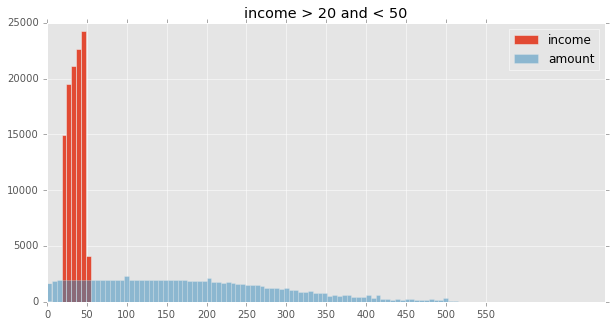



iteration 1
name 50 to 80
std 145.233706989
mean 237.451307512
median 228.0
max_mult 13.6
med_mult 3.539473684210526
min_mult 0.0126582278481
q98 563.0
q02 14.0
q75 341.0
q25 117.0
iqr 224.0
min_q -219.0
max_q 677.0
count of loans 149167
pct of total loans 6.72968039579


iteration 2
name 50 to 80
std 144.725370014
mean 237.079728
median 228.0
max_mult 13.5
med_mult 3.537037037037037
min_mult 0.0126582278481
q98 560.0
q02 14.0
q75 341.0
q25 117.0
iqr 224.0
min_q -219.0
max_q 677.0
count of loans 149167
pct of total loans 6.72968039579


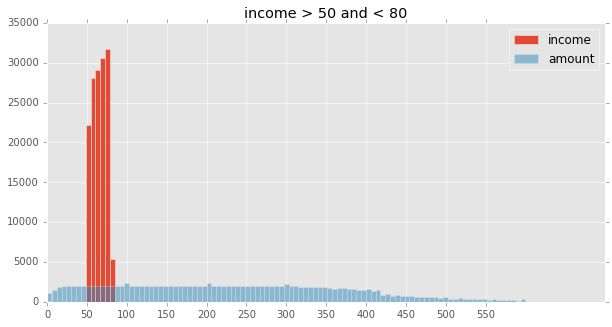



iteration 1
name 80 to 110
std 172.829605739
mean 293.941086423
median 284.0
max_mult 10.4125
med_mult 3.0093457943925235
min_mult 0.00917431192661
q98 651.0
q02 23.0
q75 420.0
q25 149.0
iqr 271.0
min_q -257.5
max_q 826.5
count of loans 179258
pct of total loans 8.08723811827


iteration 2
name 80 to 110
std 172.695008931
mean 293.844420553
median 284.0
max_mult 10.3125
med_mult 3.0091743119266057
min_mult 0.00917431192661
q98 650.0
q02 23.0
q75 420.0
q25 149.0
iqr 271.0
min_q -257.5
max_q 826.5
count of loans 179258
pct of total loans 8.08723811827


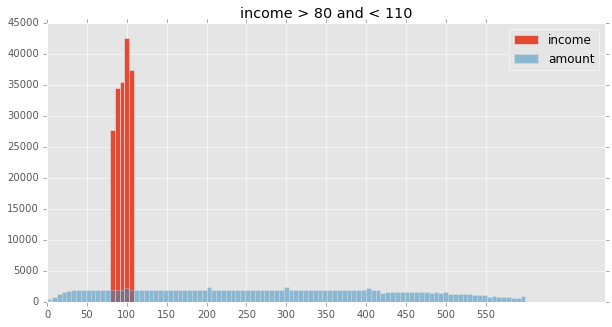



iteration 1
name 110 to 140
std 196.010149811
mean 345.399719134
median 333.0
max_mult 8.75454545455
med_mult 2.671875
min_mult 0.00719424460432
q98 750.0
q02 35.0
q75 494.0
q25 183.0
iqr 311.0
min_q -283.5
max_q 960.5
count of loans 199283
pct of total loans 8.99066749558


iteration 2
name 110 to 140
std 195.934678019
mean 345.346581322
median 333.0
max_mult 8.72727272727
med_mult 2.671875
min_mult 0.00719424460432
q98 750.0
q02 35.0
q75 494.0
q25 183.0
iqr 311.0
min_q -283.5
max_q 960.5
count of loans 199283
pct of total loans 8.99066749558


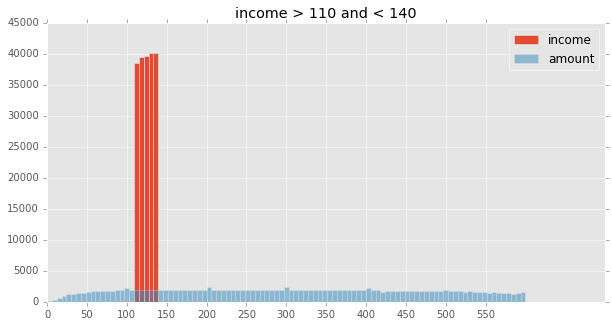



iteration 1
name 140 to 170
std 215.105084495
mean 390.45099794
median 371.0
max_mult 7.5
med_mult 2.404255319148936
min_mult 0.00591715976331
q98 863.0
q02 50.0
q75 548.0
q25 215.0
iqr 333.0
min_q -284.5
max_q 1047.5
count of loans 204711
pct of total loans 9.2355521228


iteration 2
name 140 to 170
std 214.887073317
mean 390.292022428
median 371.0
max_mult 7.35460992908
med_mult 2.4038461538461537
min_mult 0.00591715976331
q98 861.0
q02 50.0
q75 548.0
q25 215.0
iqr 333.0
min_q -284.5
max_q 1047.5
count of loans 204711
pct of total loans 9.2355521228


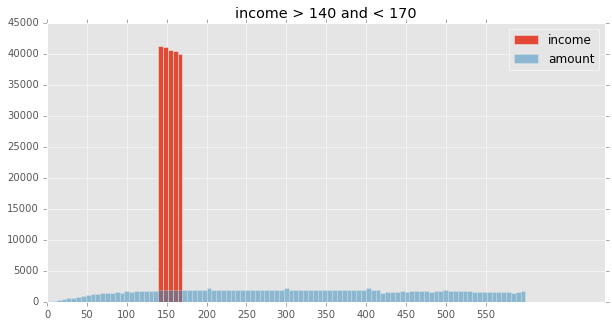



iteration 1
name 170 to 200
std 230.818303912
mean 431.978304113
median 406.0
max_mult 6.61764705882
med_mult 2.2076502732240435
min_mult 0.00502512562814
q98 950.0
q02 63.0
q75 595.0
q25 248.0
iqr 347.0
min_q -272.5
max_q 1115.5
count of loans 195768
pct of total loans 8.83208800688


iteration 2
name 170 to 200
std 230.01926894
mean 431.377357809
median 405.0
max_mult 6.55882352941
med_mult 2.2060301507537687
min_mult 0.00502512562814
q98 948.0
q02 63.0
q75 595.0
q25 247.0
iqr 348.0
min_q -275.0
max_q 1117.0
count of loans 195768
pct of total loans 8.83208800688


iteration 3
name 170 to 200
std 230.01926894
mean 431.377357809
median 405.0
max_mult 6.55882352941
med_mult 2.2060301507537687
min_mult 0.00502512562814
q98 948.0
q02 63.0
q75 595.0
q25 247.0
iqr 348.0
min_q -275.0
max_q 1117.0
count of loans 195768
pct of total loans 8.83208800688


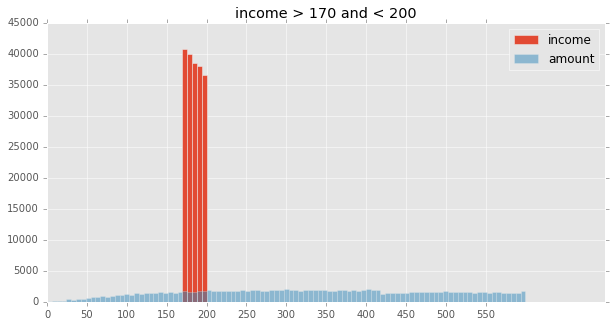



iteration 1
name 200 to 230
std 248.364653759
mean 473.674784533
median 448.0
max_mult 6.04
med_mult 2.090047393364929
min_mult 0.00442477876106
q98 1024.0
q02 76.0
q75 643.0
q25 277.0
iqr 366.0
min_q -272.0
max_q 1192.0
count of loans 176495
pct of total loans 7.96258516598


iteration 2
name 200 to 230
std 246.550011562
mean 472.277195583
median 447.0
max_mult 5.955
med_mult 2.085972850678733
min_mult 0.00442477876106
q98 1008.0
q02 76.0
q75 642.0
q25 277.0
iqr 365.0
min_q -270.5
max_q 1189.5
count of loans 176495
pct of total loans 7.96258516598


iteration 3
name 200 to 230
std 246.327391969
mean 472.103941108
median 447.0
max_mult 5.945
med_mult 2.085308056872038
min_mult 0.00442477876106
q98 1007.0
q02 76.0
q75 641.0
q25 277.0
iqr 364.0
min_q -269.0
max_q 1187.0
count of loans 176495
pct of total loans 7.96258516598


iteration 4
name 200 to 230
std 246.227140933
mean 472.025742415
median 447.0
max_mult 5.93
med_mult 2.085
min_mult 0.00442477876106
q98 1005.0
q02 76.0
q75 641.0

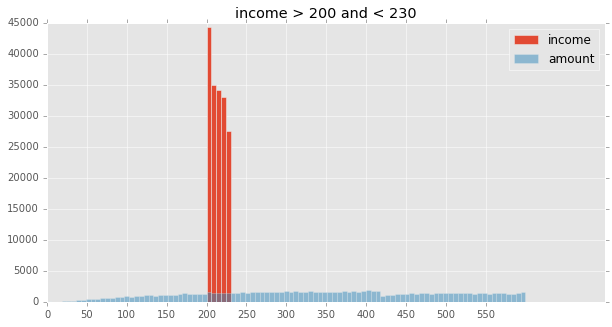



iteration 1
name 230 to 260
std 268.354431972
mean 514.575373453
median 490.0
max_mult 5.65217391304
med_mult 2.0118577075098814
min_mult 0.00395256916996
q98 1134.0
q02 85.0
q75 694.0
q25 304.0
iqr 390.0
min_q -281.0
max_q 1279.0
count of loans 147283
pct of total loans 6.64468359444


iteration 2
name 230 to 260
std 265.607457086
mean 512.437704011
median 490.0
max_mult 5.54782608696
med_mult 2.007905138339921
min_mult 0.00395256916996
q98 1120.0
q02 85.0
q75 692.0
q25 303.0
iqr 389.0
min_q -280.5
max_q 1275.5
count of loans 147283
pct of total loans 6.64468359444


iteration 3
name 230 to 260
std 265.49372523
mean 512.347834808
median 490.0
max_mult 5.54347826087
med_mult 2.007843137254902
min_mult 0.00395256916996
q98 1120.0
q02 85.0
q75 692.0
q25 303.0
iqr 389.0
min_q -280.5
max_q 1275.5
count of loans 147283
pct of total loans 6.64468359444


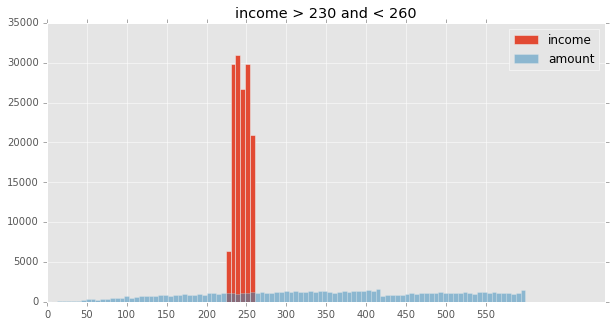



iteration 1
name 260 to 290
std 287.852845043
mean 552.345910665
median 526.0
max_mult 5.30769230769
med_mult 1.9227941176470589
min_mult 0.00353356890459
q98 1230.0
q02 96.0
q75 737.0
q25 325.0
iqr 412.0
min_q -293.0
max_q 1355.0
count of loans 119711
pct of total loans 5.40077074594


iteration 2
name 260 to 290
std 285.118360189
mean 550.155872967
median 525.0
max_mult 5.19230769231
med_mult 1.9185185185185185
min_mult 0.00353356890459
q98 1212.0
q02 96.0
q75 735.0
q25 325.0
iqr 410.0
min_q -290.0
max_q 1350.0
count of loans 119711
pct of total loans 5.40077074594


iteration 3
name 260 to 290
std 283.891192534
mean 549.157784574
median 525.0
max_mult 5.18846153846
med_mult 1.9166666666666667
min_mult 0.00353356890459
q98 1200.0
q02 96.0
q75 734.0
q25 325.0
iqr 409.0
min_q -288.5
max_q 1347.5
count of loans 119711
pct of total loans 5.40077074594


iteration 4
name 260 to 290
std 283.731573422
mean 549.028051917
median 525.0
max_mult 5.17692307692
med_mult 1.916376306620209
min_mu

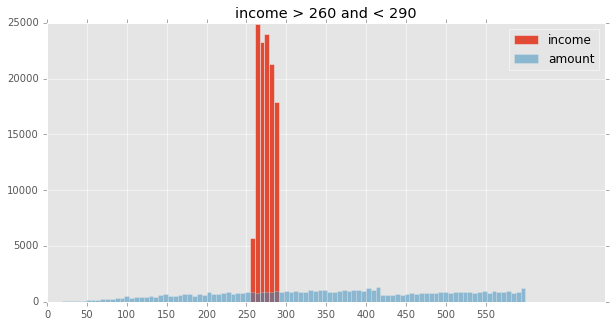



iteration 1
name 290 to 320
std 321.952420354
mean 600.086501812
median 566.0
max_mult 5.24137931034
med_mult 1.8662420382165605
min_mult 0.00324675324675
q98 1360.0
q02 100.0
q75 800.0
q25 346.0
iqr 454.0
min_q -335.0
max_q 1481.0
count of loans 97736
pct of total loans 4.40936697234


iteration 2
name 290 to 320
std 316.166635081
mean 595.414197724
median 564.0
max_mult 5.1
med_mult 1.8587774294670847
min_mult 0.00324675324675
q98 1331.0
q02 100.0
q75 799.0
q25 345.0
iqr 454.0
min_q -336.0
max_q 1480.0
count of loans 97736
pct of total loans 4.40936697234


iteration 3
name 290 to 320
std 315.613394915
mean 594.961468963
median 564.0
max_mult 5.1
med_mult 1.8581081081081081
min_mult 0.00324675324675
q98 1330.0
q02 100.0
q75 799.0
q25 345.0
iqr 454.0
min_q -336.0
max_q 1480.0
count of loans 97736
pct of total loans 4.40936697234


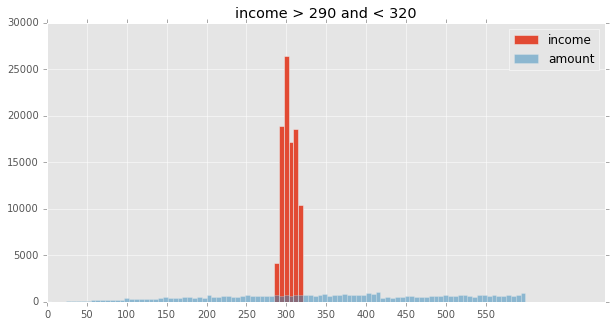



iteration 1
name 320 to 350
std 343.668692069
mean 638.070217039
median 600.0
max_mult 5.096875
med_mult 1.7994186046511629
min_mult 0.00290697674419
q98 1445.0
q02 104.48
q75 860.0
q25 364.0
iqr 496.0
min_q -380.0
max_q 1604.0
count of loans 78436
pct of total loans 3.53864602441


iteration 2
name 320 to 350
std 341.607047171
mean 636.436733422
median 600.0
max_mult 5.0
med_mult 1.7975077881619939
min_mult 0.00290697674419
q98 1440.0
q02 104.0
q75 857.0
q25 364.0
iqr 493.0
min_q -375.5
max_q 1596.5
count of loans 78436
pct of total loans 3.53864602441


iteration 3
name 320 to 350
std 339.635772031
mean 634.845774831
median 599.0
max_mult 4.96875
med_mult 1.7956656346749227
min_mult 0.00290697674419
q98 1428.0
q02 104.0
q75 855.0
q25 364.0
iqr 491.0
min_q -372.5
max_q 1591.5
count of loans 78436
pct of total loans 3.53864602441


iteration 4
name 320 to 350
std 339.280868272
mean 634.558786429
median 599.0
max_mult 4.96875
med_mult 1.7951807228915662
min_mult 0.00290697674419
q98 1

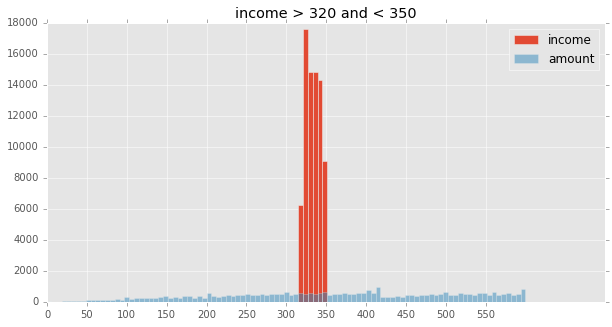



iteration 1
name 350 to 380
std 370.072414236
mean 667.790470473
median 624.0
max_mult 5.0
med_mult 1.7114285714285715
min_mult 0.00268817204301
q98 1505.0
q02 103.0
q75 904.0
q25 372.0
iqr 532.0
min_q -426.0
max_q 1702.0
count of loans 67880
pct of total loans 3.06241129248


iteration 2
name 350 to 380
std 365.405076312
mean 664.136506694
median 622.0
max_mult 4.85714285714
med_mult 1.7076502732240437
min_mult 0.00268817204301
q98 1500.0
q02 103.0
q75 900.0
q25 371.0
iqr 529.0
min_q -422.5
max_q 1693.5
count of loans 67880
pct of total loans 3.06241129248


iteration 3
name 350 to 380
std 363.577843278
mean 662.669069413
median 621.0
max_mult 4.82857142857
med_mult 1.706043956043956
min_mult 0.00268817204301
q98 1499.0
q02 103.0
q75 900.0
q25 371.0
iqr 529.0
min_q -422.5
max_q 1693.5
count of loans 67880
pct of total loans 3.06241129248


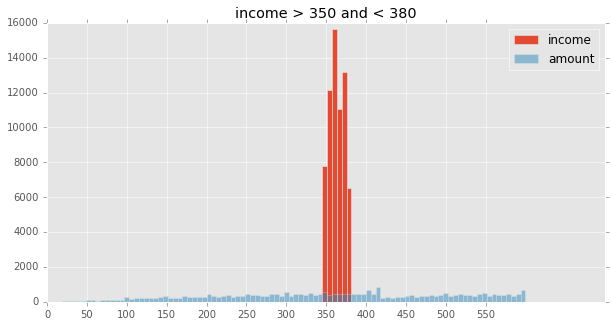



iteration 1
name 380 to 410
std 391.9280293
mean 699.083064892
median 644.0
max_mult 4.83421052632
med_mult 1.6331658291457287
min_mult 0.0025
q98 1613.0
q02 106.0
q75 950.0
q25 384.0
iqr 566.0
min_q -465.0
max_q 1799.0
count of loans 54778
pct of total loans 2.47131357955


iteration 2
name 380 to 410
std 387.084076595
mean 695.220986939
median 641.0
max_mult 4.70526315789
med_mult 1.628992628992629
min_mult 0.0025
q98 1597.0
q02 105.0
q75 948.0
q25 384.0
iqr 564.0
min_q -462.0
max_q 1794.0
count of loans 54778
pct of total loans 2.47131357955


iteration 3
name 380 to 410
std 386.751001051
mean 694.953687437
median 641.0
max_mult 4.70526315789
med_mult 1.628787878787879
min_mult 0.0025
q98 1594.0
q02 105.0
q75 947.75
q25 384.0
iqr 563.75
min_q -461.625
max_q 1793.375
count of loans 54778
pct of total loans 2.47131357955


iteration 4
name 380 to 410
std 386.751001051
mean 694.953687437
median 641.0
max_mult 4.70526315789
med_mult 1.628787878787879
min_mult 0.0025
q98 1594.0
q02 105

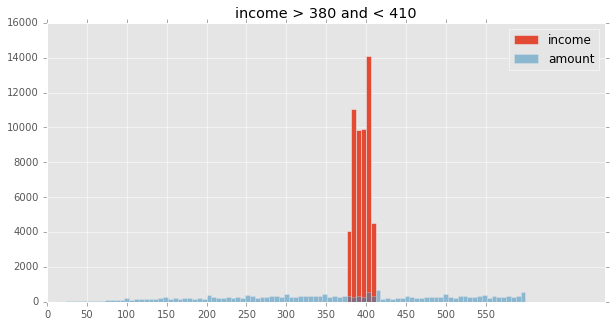



iteration 1
name 410 to 440
std 424.263329414
mean 744.526072743
median 684.0
max_mult 4.79368932039
med_mult 1.6166281755196306
min_mult 0.00231481481481
q98 1750.0
q02 106.0
q75 1000.0
q25 400.0
iqr 600.0
min_q -500.0
max_q 1900.0
count of loans 44542
pct of total loans 2.00951567162


iteration 2
name 410 to 440
std 415.790105193
mean 737.70144621
median 680.0
max_mult 4.62682926829
med_mult 1.6091954022988506
min_mult 0.00231481481481
q98 1700.0
q02 106.0
q75 999.0
q25 400.0
iqr 599.0
min_q -498.5
max_q 1897.5
count of loans 44542
pct of total loans 2.00951567162


iteration 3
name 410 to 440
std 415.790105193
mean 737.70144621
median 680.0
max_mult 4.62682926829
med_mult 1.6091954022988506
min_mult 0.00231481481481
q98 1700.0
q02 106.0
q75 999.0
q25 400.0
iqr 599.0
min_q -498.5
max_q 1897.5
count of loans 44542
pct of total loans 2.00951567162


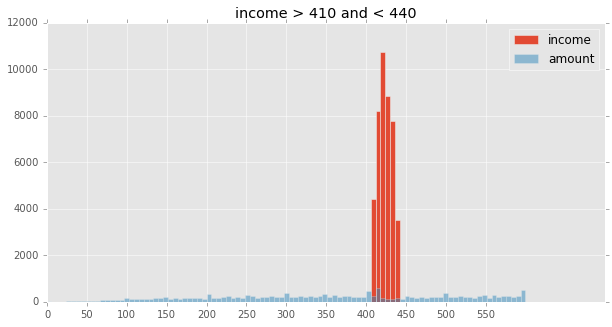



iteration 1
name 440 to 470
std 451.352544046
mean 773.769299796
median 703.0
max_mult 4.70588235294
med_mult 1.555793991416309
min_mult 0.00226757369615
q98 1874.04
q02 107.0
q75 1050.0
q25 408.0
iqr 642.0
min_q -555.0
max_q 2013.0
count of loans 37357
pct of total loans 1.68536385759


iteration 2
name 440 to 470
std 448.339997466
mean 771.360567755
median 700.0
max_mult 4.54545454545
med_mult 1.5540689696318835
min_mult 0.00226757369615
q98 1848.0
q02 107.0
q75 1050.0
q25 408.0
iqr 642.0
min_q -555.0
max_q 2013.0
count of loans 37357
pct of total loans 1.68536385759


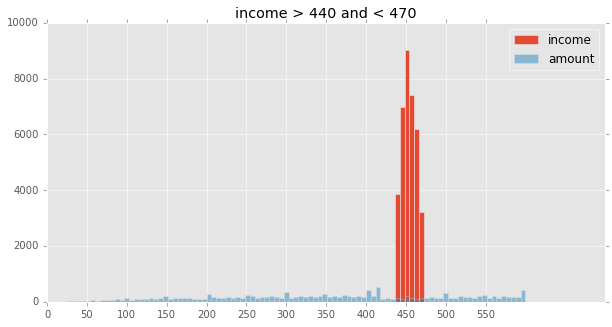



iteration 1
name 470 to 500
std 473.104029878
mean 799.294051627
median 720.0
max_mult 4.6186440678
med_mult 1.486868686868687
min_mult 0.0020325203252
q98 1940.0
q02 105.0
q75 1100.0
q25 415.0
iqr 685.0
min_q -612.5
max_q 2127.5
count of loans 31725
pct of total loans 1.43127575507


iteration 2
name 470 to 500
std 468.756746242
mean 795.881827241
median 720.0
max_mult 4.49576271186
med_mult 1.4854166666666666
min_mult 0.0020325203252
q98 1918.0
q02 105.0
q75 1100.0
q25 415.0
iqr 685.0
min_q -612.5
max_q 2127.5
count of loans 31725
pct of total loans 1.43127575507


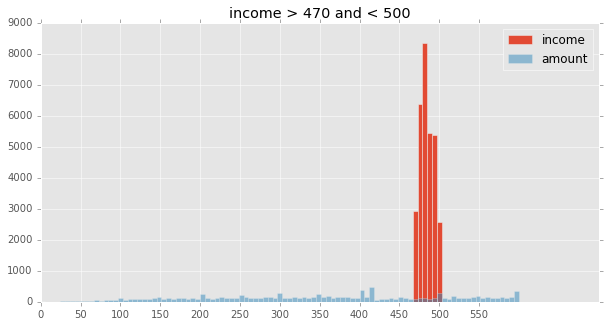



iteration 1
name 500 to 530
std 500.630373215
mean 833.594410744
median 744.0
max_mult 4.692
med_mult 1.4509803921568627
min_mult 0.00196078431373
q98 2000.0
q02 112.0
q75 1160.0
q25 417.0
iqr 743.0
min_q -697.5
max_q 2274.5
count of loans 29021
pct of total loans 1.30928459221


iteration 2
name 500 to 530
std 493.718585573
mean 828.351537758
median 742.0
max_mult 4.54
med_mult 1.4477477477477478
min_mult 0.00196078431373
q98 2000.0
q02 112.0
q75 1150.0
q25 417.0
iqr 733.0
min_q -682.5
max_q 2249.5
count of loans 29021
pct of total loans 1.30928459221


iteration 3
name 500 to 530
std 491.598074412
mean 826.691668135
median 740.0
max_mult 4.496
med_mult 1.445736434108527
min_mult 0.00196078431373
q98 1999.0
q02 112.0
q75 1150.0
q25 417.0
iqr 733.0
min_q -682.5
max_q 2249.5
count of loans 29021
pct of total loans 1.30928459221


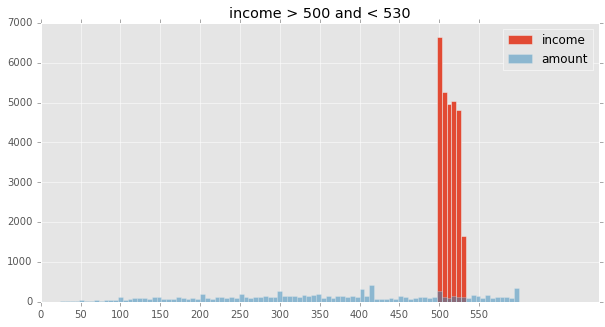



iteration 1
name 530 to 560
std 527.097342673
mean 860.811553733
median 760.0
max_mult 4.63396226415
med_mult 1.3984962406015038
min_mult 0.0179211469534
q98 2100.0
q02 108.0
q75 1200.0
q25 417.0
iqr 783.0
min_q -757.5
max_q 2374.5
count of loans 23345
pct of total loans 1.05321142639


iteration 2
name 530 to 560
std 518.568561465
mean 854.350245356
median 754.0
max_mult 4.45009416196
med_mult 1.3924288929813793
min_mult 0.0179211469534
q98 2040.0
q02 108.0
q75 1200.0
q25 417.0
iqr 783.0
min_q -757.5
max_q 2374.5
count of loans 23345
pct of total loans 1.05321142639


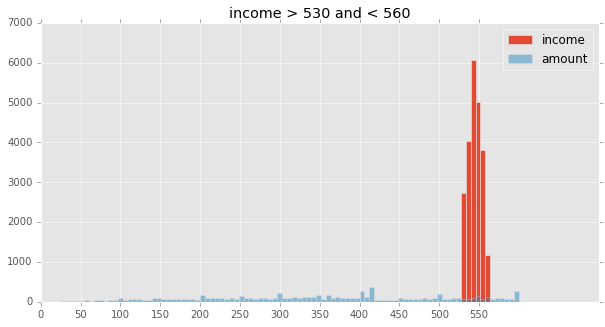



iteration 1
name 560 to 590
std 543.804949787
mean 892.655083793
median 799.0
max_mult 4.46428571429
med_mult 1.3840830449826989
min_mult 0.00520833333333
q98 2193.48
q02 111.0
q75 1250.0
q25 448.0
iqr 802.0
min_q -755.0
max_q 2453.0
count of loans 18935
pct of total loans 0.854253945539


iteration 2
name 560 to 590
std 535.886733276
mean 886.637824475
median 796.0
max_mult 4.35943060498
med_mult 1.3796133567662565
min_mult 0.00520833333333
q98 2125.88
q02 111.0
q75 1250.0
q25 445.0
iqr 805.0
min_q -762.5
max_q 2457.5
count of loans 18935
pct of total loans 0.854253945539


iteration 3
name 560 to 590
std 535.886733276
mean 886.637824475
median 796.0
max_mult 4.35943060498
med_mult 1.3796133567662565
min_mult 0.00520833333333
q98 2125.88
q02 111.0
q75 1250.0
q25 445.0
iqr 805.0
min_q -762.5
max_q 2457.5
count of loans 18935
pct of total loans 0.854253945539


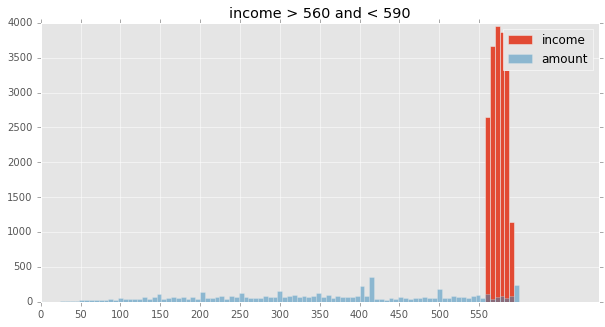



iteration 1
name 590 to 620
std 570.55006596
mean 911.900969828
median 800.0
max_mult 4.39932318105
med_mult 1.33
min_mult 0.00332225913621
q98 2279.82
q02 109.0
q75 1280.0
q25 443.0
iqr 837.0
min_q -812.5
max_q 2535.5
count of loans 18892
pct of total loans 0.852313997313


iteration 2
name 590 to 620
std 563.69065264
mean 906.606940165
median 800.0
max_mult 4.25378151261
med_mult 1.3266666666666667
min_mult 0.00332225913621
q98 2250.0
q02 109.0
q75 1276.0
q25 440.0
iqr 836.0
min_q -814.0
max_q 2530.0
count of loans 18892
pct of total loans 0.852313997313


iteration 3
name 590 to 620
std 563.13194036
mean 906.167225346
median 800.0
max_mult 4.24237288136
med_mult 1.3266666666666667
min_mult 0.00332225913621
q98 2240.3
q02 108.9
q75 1275.0
q25 440.0
iqr 835.0
min_q -812.5
max_q 2527.5
count of loans 18892
pct of total loans 0.852313997313


iteration 4
name 590 to 620
std 563.020709574
mean 906.079480941
median 800.0
max_mult 4.24237288136
med_mult 1.3266666666666667
min_mult 0.0033

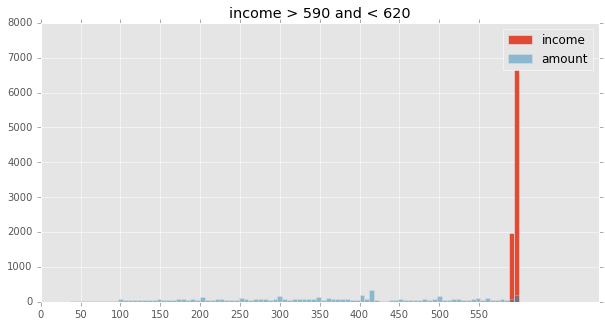



iteration 1
name 620 to 650
std 586.860826616
mean 933.547413486
median 825.0
max_mult 4.32850241546
med_mult 1.3031746031746032
min_mult 0.00156494522692
q98 2391.72
q02 110.0
q75 1313.0
q25 447.0
iqr 866.0
min_q -852.0
max_q 2612.0
count of loans 14282
pct of total loans 0.644333501462


iteration 2
name 620 to 650
std 580.476895608
mean 928.640572451
median 820.0
max_mult 4.1935483871
med_mult 1.297427652733119
min_mult 0.00156494522692
q98 2323.08
q02 110.0
q75 1308.5
q25 444.0
iqr 864.5
min_q -852.75
max_q 2605.25
count of loans 14282
pct of total loans 0.644333501462


iteration 3
name 620 to 650
std 580.323781137
mean 928.520395019
median 820.0
max_mult 4.1935483871
med_mult 1.2973836229236801
min_mult 0.00156494522692
q98 2320.54
q02 110.0
q75 1308.0
q25 444.0
iqr 864.0
min_q -852.0
max_q 2604.0
count of loans 14282
pct of total loans 0.644333501462


iteration 4
name 620 to 650
std 580.323781137
mean 928.520395019
median 820.0
max_mult 4.1935483871
med_mult 1.297383622923680

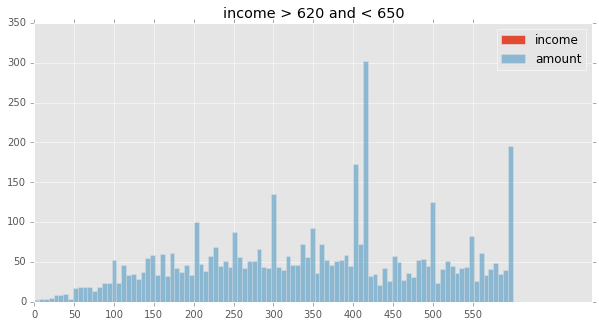



iteration 1
name 650 to 680
std 610.675384615
mean 966.743944637
median 855.0
max_mult 4.26923076923
med_mult 1.2951807228915662
min_mult 0.00150602409639
q98 2450.0
q02 114.0
q75 1367.5
q25 462.5
iqr 905.0
min_q -895.0
max_q 2725.0
count of loans 13846
pct of total loans 0.624663328753


iteration 2
name 650 to 680
std 605.37029028
mean 962.661304604
median 852.0
max_mult 4.15902140673
med_mult 1.2906641262928689
min_mult 0.00150602409639
q98 2400.0
q02 114.0
q75 1364.0
q25 460.0
iqr 904.0
min_q -896.0
max_q 2720.0
count of loans 13846
pct of total loans 0.624663328753


iteration 3
name 650 to 680
std 604.538741446
mean 962.01240127
median 852.0
max_mult 4.15384615385
med_mult 1.2893939393939393
min_mult 0.00150602409639
q98 2400.0
q02 114.0
q75 1362.5
q25 460.0
iqr 902.5
min_q -893.75
max_q 2716.25
count of loans 13846
pct of total loans 0.624663328753


iteration 4
name 650 to 680
std 604.372523701
mean 961.882695999
median 852.0
max_mult 4.15384615385
med_mult 1.2893939393939393

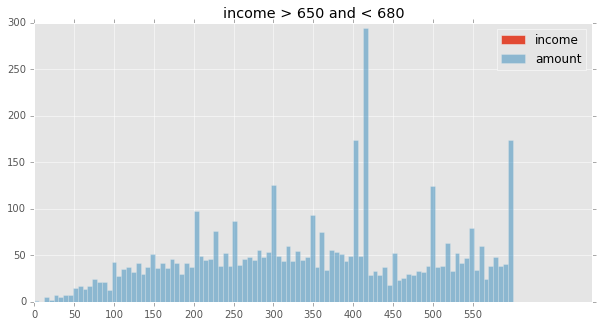



iteration 1
name 680 to 710
std 611.440058217
mean 972.29033929
median 866.0
max_mult 4.0700729927
med_mult 1.24822695035461
min_mult 0.0113798008535
q98 2460.36
q02 118.0
q75 1365.0
q25 471.5
iqr 893.5
min_q -868.75
max_q 2705.25
count of loans 11856
pct of total loans 0.534884329459


iteration 2
name 680 to 710
std 604.915732412
mean 967.226147186
median 863.0
max_mult 3.97058823529
med_mult 1.2457142857142858
min_mult 0.0113798008535
q98 2415.0
q02 118.0
q75 1360.0
q25 470.0
iqr 890.0
min_q -865.0
max_q 2695.0
count of loans 11856
pct of total loans 0.534884329459


iteration 3
name 680 to 710
std 602.261493671
mean 965.123352982
median 860.0
max_mult 3.90909090909
med_mult 1.2439355952070852
min_mult 0.0113798008535
q98 2400.6
q02 118.0
q75 1360.0
q25 469.0
iqr 891.0
min_q -867.5
max_q 2696.5
count of loans 11856
pct of total loans 0.534884329459


iteration 4
name 680 to 710
std 602.261493671
mean 965.123352982
median 860.0
max_mult 3.90909090909
med_mult 1.2439355952070852
min

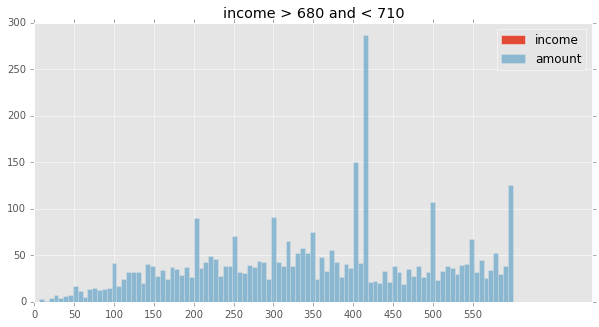



iteration 1
name 710 to 740
std 651.373724798
mean 1006.24277183
median 899.0
max_mult 4.11267605634
med_mult 1.2296195652173914
min_mult 0.00409836065574
q98 2576.16
q02 100.0
q75 1434.0
q25 480.0
iqr 954.0
min_q -951.0
max_q 2865.0
count of loans 10808
pct of total loans 0.487603730836


iteration 2
name 710 to 740
std 640.247422435
mean 997.729765759
median 890.0
max_mult 4.01122019635
med_mult 1.2251373626373627
min_mult 0.00409836065574
q98 2500.0
q02 100.0
q75 1425.0
q25 480.0
iqr 945.0
min_q -937.5
max_q 2842.5
count of loans 10808
pct of total loans 0.487603730836


iteration 3
name 710 to 740
std 636.157455839
mean 994.543399466
median 885.0
max_mult 3.94366197183
med_mult 1.2236111111111112
min_mult 0.00409836065574
q98 2500.0
q02 100.0
q75 1420.0
q25 479.0
iqr 941.0
min_q -932.5
max_q 2831.5
count of loans 10808
pct of total loans 0.487603730836


iteration 4
name 710 to 740
std 636.157455839
mean 994.543399466
median 885.0
max_mult 3.94366197183
med_mult 1.223611111111111

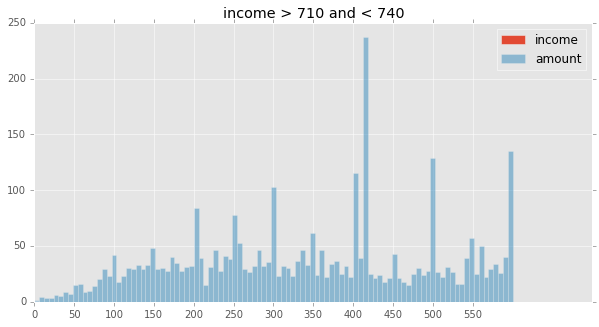

In [7]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)
bin_min = 0
bin_max = 20
bin_step = 30
pct_of_loans = OrderedDict({})
first = True
while bin_max < 750:#bank_df.income.max():
    graph_bin = bank_df[(bank_df.income >=bin_min) & (bank_df.income < bin_max)] #create bin of of amount for selected income
    #set descriptive stats
    bin_stats = OrderedDict({})
    bin_stats['name'] = str(bin_min) + ' to ' + str(bin_max)
    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['med_mult'] = graph_bin.mult.median()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    bin_stats['pct of total loans'] = (graph_bin.amount.count() / bank_df.income.count()) * 100

    #iterate over dataframe bin to remove outliers using IQR * 1.5
    count=1
    while True:
        #remove outliers
        start_max_q = bin_stats['max_q']
        graph_bin = graph_bin[(graph_bin.amount > bin_stats['min_q']) & (graph_bin.amount < bin_stats['max_q'])]
        print('\n\niteration {num}'.format(num=count))
        #reset bin stats to reflect IQR cutoffs
        bin_stats['std']= graph_bin.amount.std()
        bin_stats['mean'] = graph_bin.amount.mean()
        bin_stats['median'] = graph_bin.amount.median()
        bin_stats['max_mult'] = graph_bin.mult.max()
        bin_stats['med_mult'] = graph_bin.mult.median()
        bin_stats['min_mult'] = graph_bin.mult.min()
        bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
        bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
        bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
        bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
        bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
        bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
        bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']

        count+=1
        for key, value in bin_stats.items(): #print descriptive stats
            print(key,value)
        
        if start_max_q == bin_stats['max_q']:
            break
            
    if first: 
        first=False
        bin_df = pd.DataFrame(bin_stats, index=range(1)) #instantiate initial dataframe
    else:
        concat_df = pd.DataFrame(bin_stats, index=range(1)) #instantiate subsequent dataframe 
        bin_df = pd.concat([bin_df, concat_df], axis=0) #concatenate dataframes each cycle
    

    
    amt = graph_bin.amount#.apply(sqrt)
    inc = graph_bin.income#.apply(sqrt) #square roots show much nicer distributions of amount to income
    xmin = 0 #set minimum x axis value
    xmax = 600 #set maximum x axis value
    xsteps= 100 #set steps on x axis (bins)
    bins = np.linspace(xmin,xmax, xsteps)
    #print(bins)
    bin_viz = plt.figure(figsize=(10,5))
    plt.hist(inc, bins, label='income', alpha=1)
    plt.hist(amt, bins, label='amount', alpha=.5)
    plt.title('income > '+str(bin_min)+' and < '+str(bin_max))
    plt.legend(loc='upper right')
    plt.xticks(np.arange(xmin,xmax, 50))
    ax = plt.subplot()
    #ax.set_ylim(0, 2000)
    plt.show(bin_viz)
    bin_min=bin_max
    bin_max += bin_step
    pct_of_loans[bin_max] = bin_stats['pct of total loans']
    
path = 'linked_dist_stats/'
if not os.path.exists(path):
    os.makedirs(path)
bin_df.to_csv(path+'{count}IQR_all.csv'.format(count=count))

In [17]:

bin_df.reset_index(inplace=True, drop=True) #set an integer index instead of index passed at creation
bin_df.head(20)

,name,std,mean,median,max_mult,med_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
0,0 to 20,88.044178,126.841427,110.0,368.000000,10.142857,0.052632,338.00,7.0,181.00,56.0,125.00,-131.500,368.500,41276,1.862170
1,20 to 50,114.643708,176.717882,164.0,25.500000,4.738095,0.020408,444.00,8.0,254.00,83.0,171.00,-173.500,510.500,110307,4.976509
2,50 to 80,144.725370,237.079728,228.0,13.500000,3.537037,0.012658,560.00,14.0,341.00,117.0,224.00,-219.000,677.000,149167,6.729680
3,80 to 110,172.695009,293.844421,284.0,10.312500,3.009174,0.009174,650.00,23.0,420.00,149.0,271.00,-257.500,826.500,179258,8.087238
4,110 to 140,195.934678,345.346581,333.0,8.727273,2.671875,0.007194,750.00,35.0,494.00,183.0,311.00,-283.500,960.500,199283,8.990667
5,140 to 170,214.887073,390.292022,371.0,7.354610,2.403846,0.005917,861.00,50.0,548.00,215.0,333.00,-284.500,1047.500,204711,9.235552
6,170 to 200,230.019269,431.377358,405.0,6.558824,2.206030,0.005025,948.00,63.0,595.00,247.0,348.00,-275.000,1117.000,195768,8.832088
7,200 to 230,246.227141,472.025742,447.0,5.930000,2.085000,0.004425,1005.00,76.0,641.00,277.0,364.00,-269.000,1187.000,176495,7.962585
8,230 to 260,265.493725,512.347835,490.0,5.543478,2.007843,0.003953,1120.00,85.0,692.00,303.0,389.00,-280.500,1275.500,147283,6.644684
9,260 to 290,283.731573,549.028052,525.0,5.176923,1.916376,0.003534,1200.00,96.0,734.00,325.0,409.00,-288.500,1347.500,119711,5.400771


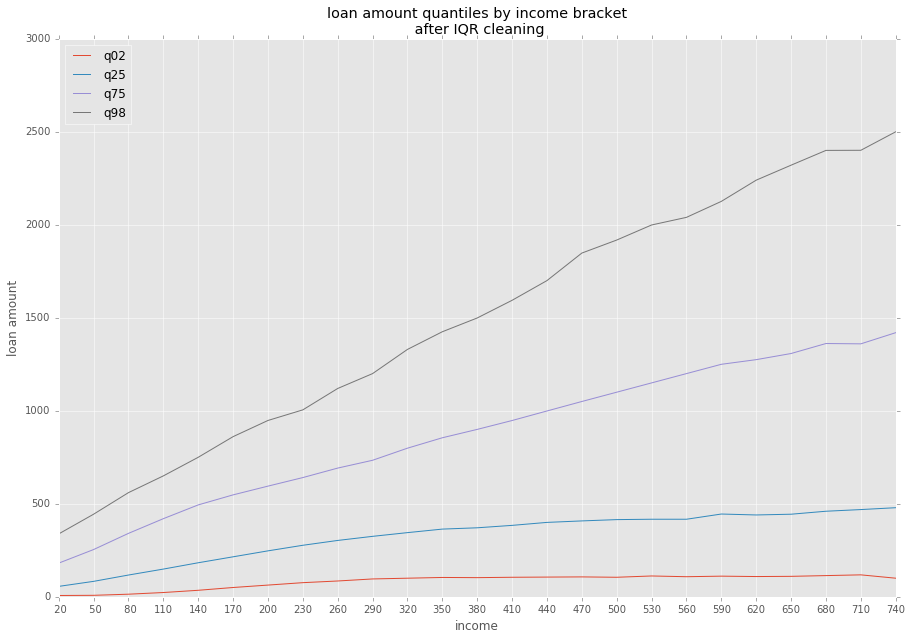

In [16]:
fig = plt.figure(figsize=(15,10))
xticks=[x[-3:] for x in bin_df.name] #get xtick names as list
ax = plt.subplot()
x = range(len(bin_df.name))
plt.xticks(x,xticks) #set xtick names


y = bin_df.q02
y1 = bin_df.q25
y2 = bin_df.q75
y3 = bin_df.q98
plt.plot(x,y, label='q02')
plt.plot(x,y1, label='q25')
plt.plot(x,y2, label='q75')
plt.plot(x,y3, label='q98')
ax=plt.subplot()
ax.set_ylim(0,3000)
plt.ylabel('loan amount')
plt.xlabel('income')
plt.legend(loc='upper left') #turn on legend and set location
plt.title('loan amount quantiles by income bracket\n after IQR cleaning')
plt.show(fig)